<a href="https://colab.research.google.com/github/KevinLolochum/Risklabproject/blob/master/CNNs_with_Cats_and_Dogs_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cats and dogs dataset to perform a CNN image recognition

Steps.
1. Loading data from the web since this data is not in tensorflow.
2. EDA, such as plotting the images.
3. Perform image augmentation so as to prevent overfitting in future.
4. Resize images to one size.
5. Normalize the images
6. Separate the dat into training and test
7. Set up the parameters for the model
8. Initiate/build the model with convolusions and max pooling layers
9. Train the model
9. Test the model, explore metrics such as accuracy
10. Improve the model

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import math
import matplotlib.pyplot as plt
import os # to read files from directory


Dowloading the data from the web and adding it to colab filesystme

In [59]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin= _URL, extract=True)

Assigning data from the directory to variables


In [60]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [61]:
train_cats_dir = os.path.join(train_dir, 'cats') # Training cats pictures directory
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(train_dir, 'cats')
validation_dogs_dir = os.path.join(train_dir, 'dogs')

Setting model parameters

In [62]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels
# FlOW_FROM_DIRECTORY method will load images and apply reschaling and resizing to required dimensions

In [63]:
# Understanding the data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

Data augmentation to increase data size and change shapes of images using tf.keras ImageDataGenerator method



In [64]:
# Function to show the kind of transformation that has been performed on an image
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [65]:
# Applying multiple augmentation, horizantal flipping, rotation, zooming, shifting and others.
image_gen = ImageDataGenerator(rescale=1./255, 
                               rotation_range =40,
                               height_shift_range =0.2,
                               width_shift_range =0.2,
                               zoom_range = 0.2,
                               shear_range=0.2,
                               fill_mode ='nearest',
                               horizontal_flip=True)

# loading images and applying scaling and resizing using flow_from_directory
train_data_gen = image_gen.flow_from_directory(batch_size =BATCH_SIZE,
                                                shuffle = True,
                                                directory= train_dir,
                                                target_size =(IMG_SHAPE,IMG_SHAPE))


Found 2000 images belonging to 2 classes.


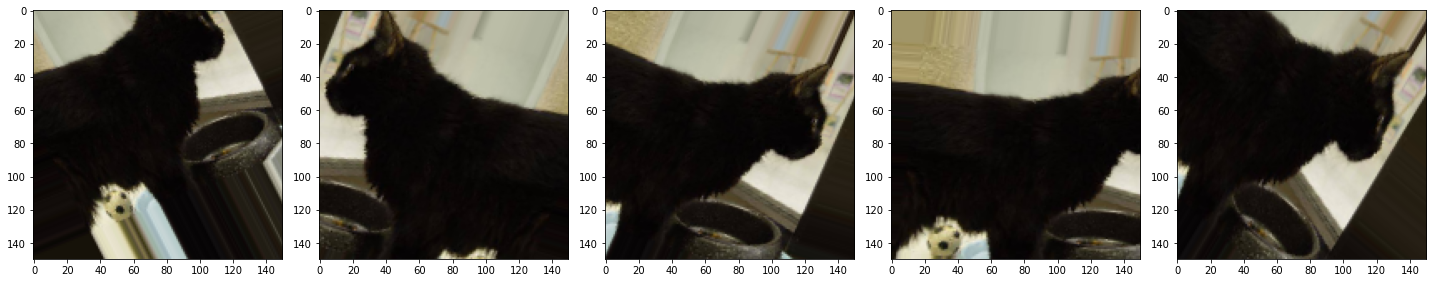

In [66]:
# Taking a random image and repeating it to see if augmentation is applied
augmented_images = [train_image_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [67]:
# The only change we need for the validation set is rescaling so that it consistent with the image sizes from the data
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size = BATCH_SIZE,
                                                  directory=validation_dir,
                                                  shuffle=True,
                                                  target_size=(IMG_SHAPE,IMG_SHAPE),
                                                  class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [68]:
# Model creation
# Model will consist of four convolusional layers with a max pool layer between them.
# Will also include a 50% dropout rate to help prevent overfitting
# Then we have a fully connected layer with 532 units and an activation function of relu
# Model will output probabiities of the two classes(dogs and cats) using sofmax activation
# Remember the list brackets
model =tf.keras.models.Sequential([
    
  tf.keras.layers.Conv2D(32,(3,3), input_shape=(150,150,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),  
  tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(2)]
   
)

In [69]:
# Compiling model using adams optimizer and the sparcecategoricalcrossentropy as the loss function because we are using softmax 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics = ['accuracy'])

In [70]:
# Looking at the layers of the model using model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)      

In [71]:
#Training the model, we will use fit_generator instead of fit because our images are comming froma generator(ImageDataGenerator)
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)


Epoch 1/100


TypeError: ignored